This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/pend.html).  I recommend having both windows open, side-by-side!


In [1]:
from copy import copy

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import display
from pydrake.all import (DiagramBuilder, Linearize, LinearQuadraticRegulator,
                         MeshcatVisualizer, RigidTransform, RotationMatrix,
                         Saturation, SceneGraph, Simulator, StartMeshcat,
                         VectorLogSink, VectorSystem, wrap_to)
from pydrake.examples.pendulum import (PendulumGeometry, PendulumParams,
                                       PendulumPlant)

from underactuated import plot_2d_phase_portrait, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders, interact

if running_as_notebook:
    mpld3.enable_notebook()


In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://e2906222-1374-46b0-af5c-4c52a177c6be.deepnoteproject.com/7000/


# Dynamics of the Simple Pendulum

I find it extremely useful to use simulation to get physical intuition about these systems.  Let's make sure we understand how the simple pendulum moves when it is exposed to a torque.

For the duration of this notebook, we'll use the equations of motion $$ml^2 \ddot\theta + b\dot\theta + mgl \sin\theta = u,$$ where $u$ is our torque input.

## Basic simulation

The pendulum is a core example in Drake.  We could certainly load it from a .urdf file, but Drake offers a Pendulum implementation that makes it convenient to manipulate the parameters (and visualize the system with different parameters).

In [3]:
def pendulum_simulation():
    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())

    # Setup visualization
    scene_graph = builder.AddSystem(SceneGraph())
    PendulumGeometry.AddToBuilder(builder, pendulum.get_state_output_port(),
                                  scene_graph)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    meshcat.Delete()
    meshcat.Set2dRenderMode(X_WC=RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0, 1, 0]))

    # Setup slider input
    meshcat.AddSlider('u', min=-5, max=5, step=.1, value=0.0)
    torque_system = builder.AddSystem(MeshcatSliders(meshcat,['u']))
    builder.Connect(torque_system.get_output_port(), pendulum.get_input_port())

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    meshcat.AddButton('Stop Simulation')

    # Set the initial conditions
    context.SetContinuousState([0.5, 0]) # theta, thetadot

    if running_as_notebook:  # Then we're not just running as a test on CI.
        simulator.set_target_realtime_rate(1.0)

        print('Use the slider in the MeshCat controls to apply elbow torque.')
        print("Press 'Stop Simulation' in MeshCat to continue.")
        while meshcat.GetButtonClicks('Stop Simulation') < 1:
            simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)
    else:
        simulator.AdvanceTo(0.1)

    meshcat.DeleteAddedControls()

pendulum_simulation()

Use the slider in the MeshCat controls to apply elbow torque.
Press 'Stop Simulation' in MeshCat to continue.


After running the cell above, you should use the "Open Controls" panel in meshcat to see the interactive slider that will control the torque.  Press the "Stop Simulation" button to regain control and continue in the notebook.

# Autapse

The simplest recurrent neural network model.  $$\dot{x} + x = \tanh(wx + u)$$

In [4]:

def autapse(x, w=1, u=0):
    """Args:
    w is feedback weight
    u is input
    """
    return -x + np.tanh(w * x + u)

Autapse = np.vectorize(autapse)
xmax = 2.
ymax = 1.
x = np.arange(-xmax, xmax, 0.01)

meshcat.Delete()
meshcat.Set2dRenderMode(xmax=xmax, xmin=-xmax, ymin=-ymax, ymax=ymax)
meshcat.SetProperty('/Grid', 'visible', True)
meshcat.SetProperty('/Axes', 'visible', True)

def update(w=1, u=0):
    # TODO(russt): Visualize fixed points here, too.
    meshcat.SetLine("autapse", np.vstack([x,0*x, Autapse(x, w=w, u=u)]), line_width=4.0)

interact(meshcat, update, w=(0,3,0.1), u=(-1.5,1.5,0.1))

Press the 'Stop Interacting' button in Meshcat to continue.


# Recurrent neural network units: LSTM and JANET

JANET (Just Another NETwork) is a simplied version of the famous Long Short-Term Memory (LSTM) model as described in https://arxiv.org/abs/1804.04849 .  Relative to the autapse model, it adds a multiplicative "forget gate":
$$\dot{x} + x = f (1-\alpha) x + (1-f)\tanh(wx + u),\\ f = \sigma(w_f x + u_f).$$
I've written it here in continuous time and also added a small "leak term", $\alpha>0$.  $\sigma()$ is the sigmoid function, with range (0,1).  When $f=0$ we have the autapse model, where "memory" is possible.  When $f=1$ we have $\dot{x} = -\alpha x$, which "forgets" by implementing a dynamics with pushing the activations back towards zero.  

In [5]:
meshcat.DeleteAddedControls()

def sigma(x):
  return 1./(1+np.exp(-x))

def janet(x, w, u, wf, uf, alpha):
    f = sigma(wf*x + uf)
    return -x + f*(1-alpha)*x + (1-f)*np.tanh(w * x + u)

Janet = np.vectorize(janet)
xmax = 2.
ymax = 1.
x = np.arange(-xmax, xmax, 0.01)

meshcat.Delete()
meshcat.Set2dRenderMode(xmax=xmax, xmin=-xmax, ymin=-ymax, ymax=ymax)
meshcat.SetProperty('/Grid', 'visible', True)
meshcat.SetProperty('/Axes', 'visible', True)

def update(w=1, u=0, wf=0, uf=0, alpha=0.1):
    # TODO(russt): Visualize fixed points here, too.
    meshcat.SetLine("janet", np.vstack([x,0*x, Janet(x, w=w, u=u, wf=wf, uf=uf, alpha=alpha)]), line_width=4.0)

interact(meshcat, update, w=(0,3,0.1), u=(-1.5,1.5,0.1), wf=(-2, 2, 0.1), uf=(-5,5,0.1), alpha=(0,1, 0.02))

Press the 'Stop Interacting' button in Meshcat to continue.


# Energy Shaping Control

In [6]:
class EnergyShapingController(VectorSystem):

    def __init__(self, pendulum):
        VectorSystem.__init__(self, 2, 1)
        self.pendulum = pendulum
        self.pendulum_context = pendulum.CreateDefaultContext()
        self.SetPendulumParams(PendulumParams())

    def SetPendulumParams(self, params):
        self.pendulum_context.get_mutable_numeric_parameter(0).SetFromVector(
            params.CopyToVector())
        self.pendulum_context.SetContinuousState([np.pi, 0])
        self.desired_energy = self.pendulum.EvalPotentialEnergy(
            self.pendulum_context)

    def DoCalcVectorOutput(self, context, pendulum_state, unused, output):
        self.pendulum_context.SetContinuousState(pendulum_state)
        params = self.pendulum_context.get_numeric_parameter(0)
        theta = pendulum_state[0]
        thetadot = pendulum_state[1]
        total_energy = self.pendulum.EvalPotentialEnergy(
            self.pendulum_context) + self.pendulum.EvalKineticEnergy(
                self.pendulum_context)
        output[:] = (params.damping() * thetadot - .1 * thetadot *
                     (total_energy - self.desired_energy))


def PhasePlot(pendulum):
    phase_plot = plt.figure()
    ax = phase_plot.gca()
    theta_lim = [-np.pi, 3. * np.pi]
    ax.set_xlim(theta_lim)
    ax.set_ylim(-10., 10.)

    theta = np.linspace(theta_lim[0], theta_lim[1], 601)  # 4*k + 1
    thetadot = np.zeros(theta.shape)
    context = pendulum.CreateDefaultContext()
    params = context.get_numeric_parameter(0)
    context.SetContinuousState([np.pi, 0])
    E_upright = pendulum.EvalPotentialEnergy(context)
    E = [E_upright, .1 * E_upright, 1.5 * E_upright]
    for e in E:
        for i in range(theta.size):
            v = ((e + params.mass() * params.gravity() * params.length() *
                  np.cos(theta[i])) /
                 (.5 * params.mass() * params.length() * params.length()))
            if (v >= 0):
                thetadot[i] = np.sqrt(v)
            else:
                thetadot[i] = float("nan")
        ax.plot(theta, thetadot, color=[.6, .6, .6])
        ax.plot(theta, -thetadot, color=[.6, .6, .6])

    return ax


def energy_shaping_demo():
    builder = DiagramBuilder()

    pendulum = builder.AddSystem(PendulumPlant())
    ax = PhasePlot(pendulum)
    saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    controller = builder.AddSystem(EnergyShapingController(pendulum))
    builder.Connect(pendulum.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

    logger = builder.AddSystem(VectorLogSink(2))
    builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    for i in range(5):
        context.SetTime(0.)
        context.SetContinuousState(np.random.randn(2,))
        simulator.Initialize()
        simulator.AdvanceTo(4)
        log = logger.FindLog(context)
        ax.plot(log.data()[0, :], log.data()[1, :])
        log.Clear()

    display(mpld3.display())  

energy_shaping_demo()

## Swing-up and balance

Now we will combine our simple energy shaping controller with a linear controller that stabilizes the upright fixed point once we get close enough.  We'll read more about this approach in the Acrobot and Cart-Pole notes.

In [7]:
def BalancingLQR(pendulum):
    context = pendulum.CreateDefaultContext()

    pendulum.get_input_port(0).FixValue(context, [0])
    context.SetContinuousState([np.pi, 0])

    Q = np.diag((10., 1.))
    R = [1]

    linearized_pendulum = Linearize(pendulum, context)
    (K, S) = LinearQuadraticRegulator(linearized_pendulum.A(),
                                      linearized_pendulum.B(), Q, R)
    return (K, S)


class SwingUpAndBalanceController(VectorSystem):

    def __init__(self, pendulum):
        VectorSystem.__init__(self, 2, 1)
        (self.K, self.S) = BalancingLQR(pendulum)
        self.energy_shaping = EnergyShapingController(pendulum)
        self.energy_shaping_context = self.energy_shaping.CreateDefaultContext()

        # TODO(russt): Add a witness function to tell the simulator about the
        # discontinuity when switching to LQR.

    def DoCalcVectorOutput(self, context, pendulum_state, unused, output):
        xbar = copy(pendulum_state)
        xbar[0] = wrap_to(xbar[0], 0, 2. * np.pi) - np.pi

        # If x'Sx <= 2, then use the LQR controller
        if (xbar.dot(self.S.dot(xbar)) < 2.):
            output[:] = -self.K.dot(xbar)
        else:
            self.energy_shaping.get_input_port(0).FixValue(self.energy_shaping_context, pendulum_state)
            output[:] = self.energy_shaping.get_output_port(0).Eval(self.energy_shaping_context)

def swing_up_and_balance_demo():
    builder = DiagramBuilder()

    pendulum = builder.AddSystem(PendulumPlant())
    ax = PhasePlot(pendulum)
    saturation = builder.AddSystem(Saturation(min_value=[-3], max_value=[3]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    controller = builder.AddSystem(SwingUpAndBalanceController(pendulum))
    builder.Connect(pendulum.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

    logger = builder.AddSystem(VectorLogSink(2))
    builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    for i in range(5):
        context.SetTime(0.)
        context.SetContinuousState(np.random.randn(2,))
        simulator.Initialize()
        simulator.AdvanceTo(4)
        log = logger.FindLog(context)
        ax.plot(log.data()[0, :], log.data()[1, :])
        log.Clear()

    ax.set_xlim(np.pi - 3., np.pi + 3.)
    ax.set_ylim(-5., 5.)
    display(mpld3.display())

swing_up_and_balance_demo()

# Unstable equilibrium point that attracts all trajectories

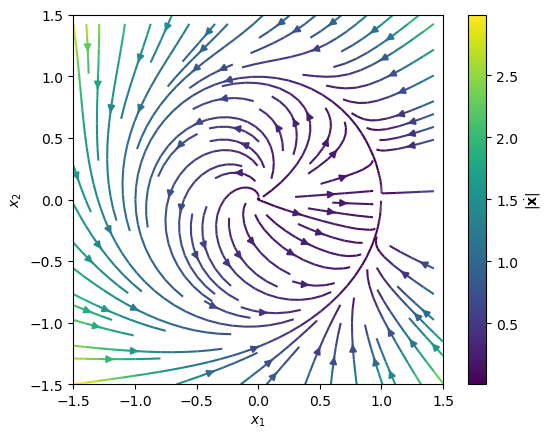

In [8]:
def dynamics(x):
    r = np.sqrt(x[0]**2 + x[1]**2)
    theta = np.arctan2(x[1], x[0])
    rdot = r*(1-r)
    thetadot = np.sin(theta/2)**2
    return rdot*np.cos(theta) - r*thetadot*np.sin(theta), rdot*np.sin(theta) + r*thetadot*np.cos(theta)

plot_2d_phase_portrait(dynamics, x1lim=(-1.5, 1.5), x2lim=(-1.5, 1.5))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e2906222-1374-46b0-af5c-4c52a177c6be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>